In [1]:
import math
from glob import glob
import os

import cv2
import numpy as np
from PIL import Image
from pdf2image import convert_from_path
from imutils import resize
from sklearn.metrics import euclidean_distances
from tqdm import tqdm
from transformers.models.deprecated.deta.image_processing_deta import masks_to_boxes
from template_extraction import *

from scoring import *
from border_and_title import *

files = [
    "../../data/original/Good/300-014820.pdf",
    "../../data/original/Good/300-014823.pdf",
    "../../data/original/Good/300-014821.pdf",
    "../../data/original/Good/300-014822.pdf"
]
# files = [
#     "../../data/original/Ugly/000.000.537.pdf",
#     "../../data/original/Ugly/000.001.296.pdf",
#     "../../data/original/Ugly/000.001.360.pdf",
#     "../../data/original/Ugly/000.001.389.pdf",
#     "../../data/original/Ugly/000.895.652.pdf",
#     "../../data/original/Ugly/000.895.659.pdf",
#     "../../data/original/Ugly/000.895.681.pdf",
#     "../../data/original/Ugly/000.895.684.pdf",
#     "../../data/original/Ugly/000.895.701 (1).pdf"
# ]
# files = [
#     "../../data/original/Ugly/000.001.024.pdf",
#     "../../data/original/Ugly/000.001.303.pdf",
#     "../../data/original/Ugly/000.001.373.pdf",
#     "../../data/original/Ugly/000.001.423.pdf",
#     "../../data/original/Ugly/000.895.692.pdf",
# ]
# files = [
#     "../../data/original/Ugly/1.pdf",
#     "../../data/original/Ugly/2.pdf",
#     "../../data/original/Ugly/3.pdf",
#     "../../data/original/Ugly/4.pdf",
#     "../../data/original/Ugly/5.pdf",
#     "../../data/original/Ugly/6.pdf",
#     "../../data/original/Ugly/7.pdf",
#     "../../data/original/Ugly/8.pdf",
#     "../../data/original/Ugly/9.pdf",
#     "../../data/original/Ugly/10.pdf",
#     "../../data/original/Ugly/11.pdf"
# ]
# files = [
#     "../../data/original/Good/15316-100-D-006_Sheet1.pdf",
#     "../../data/original/Good/15316-100-D-020_Sheet2.pdf",
#     "../../data/original/Good/15316-100-D-040_Sheet1.pdf",
#     "../../data/original/Good/15316-100-D-041_Sheet1.pdf"
# ]

font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 1
color = (255, 0, 0)
thickness = 2

def read_pdf(pdf_path):
    pages = convert_from_path(pdf_path, dpi=300)
    img = np.array(pages[0])
    img = im_resize(img)
    return img

In [2]:
structures = []

for f in files:
    img = read_pdf(f)

    title_contours, line_90, data = detect_probable_title_sections(img, return_states=True)
    ocr_result = data["ocr_result"]
    mask = data["mask"]

    im_h, im_w, _ = img.shape
    words = process_text(ocr_result, im_h, im_w)
    img_comp = img.copy()

    for idx, row in words.iterrows():
        bx1, by1, bx2, by2 = row[["x1", "y1", "x2", "y2"]].astype(int)
        cv2.rectangle(img_comp, (bx1, by1), (bx2, by2), (255, 255, 255), cv2.FILLED)

    structures.append(cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR))

Image Similarity: 86.0823%
Image Similarity: 88.7206%
Image Similarity: 85.1641%


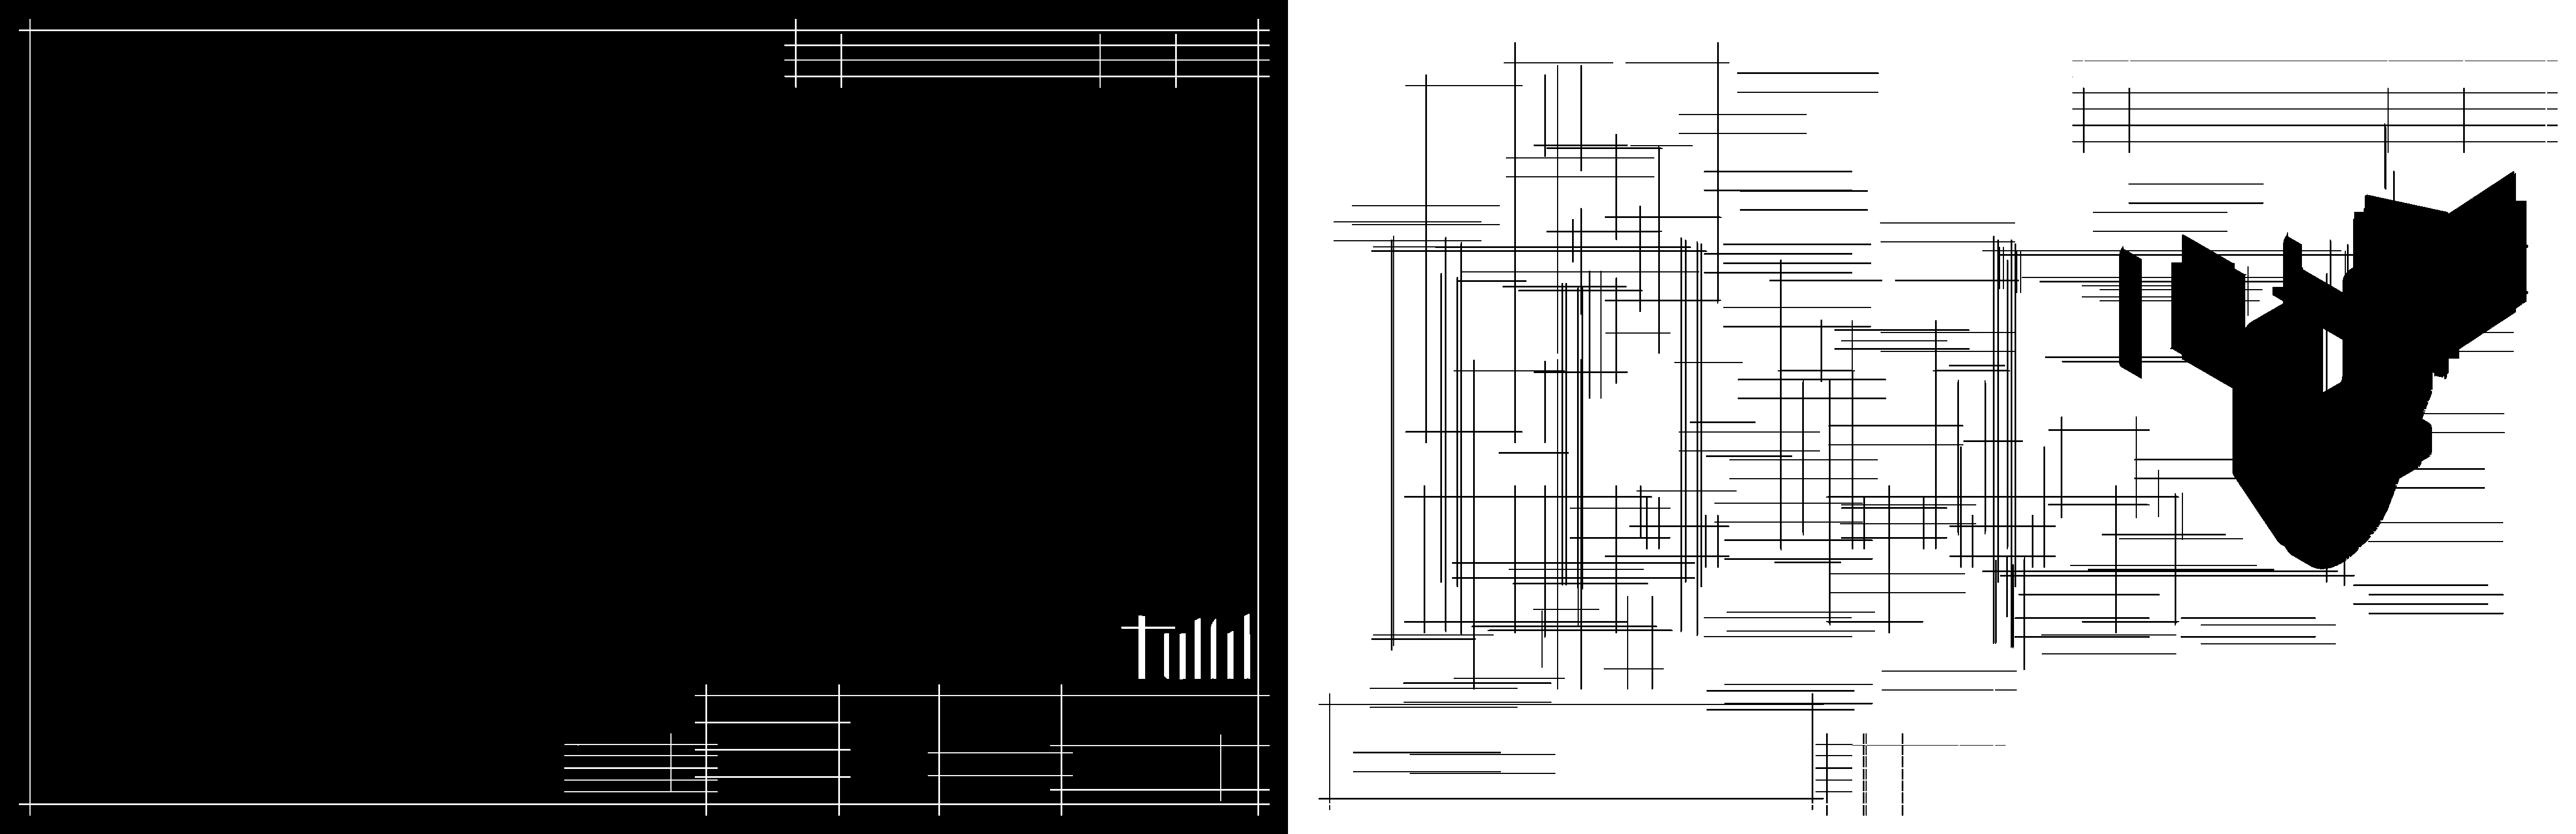

In [3]:
template, common_mask = find_common_region(structures)
Image.fromarray(np.hstack((template, common_mask)))

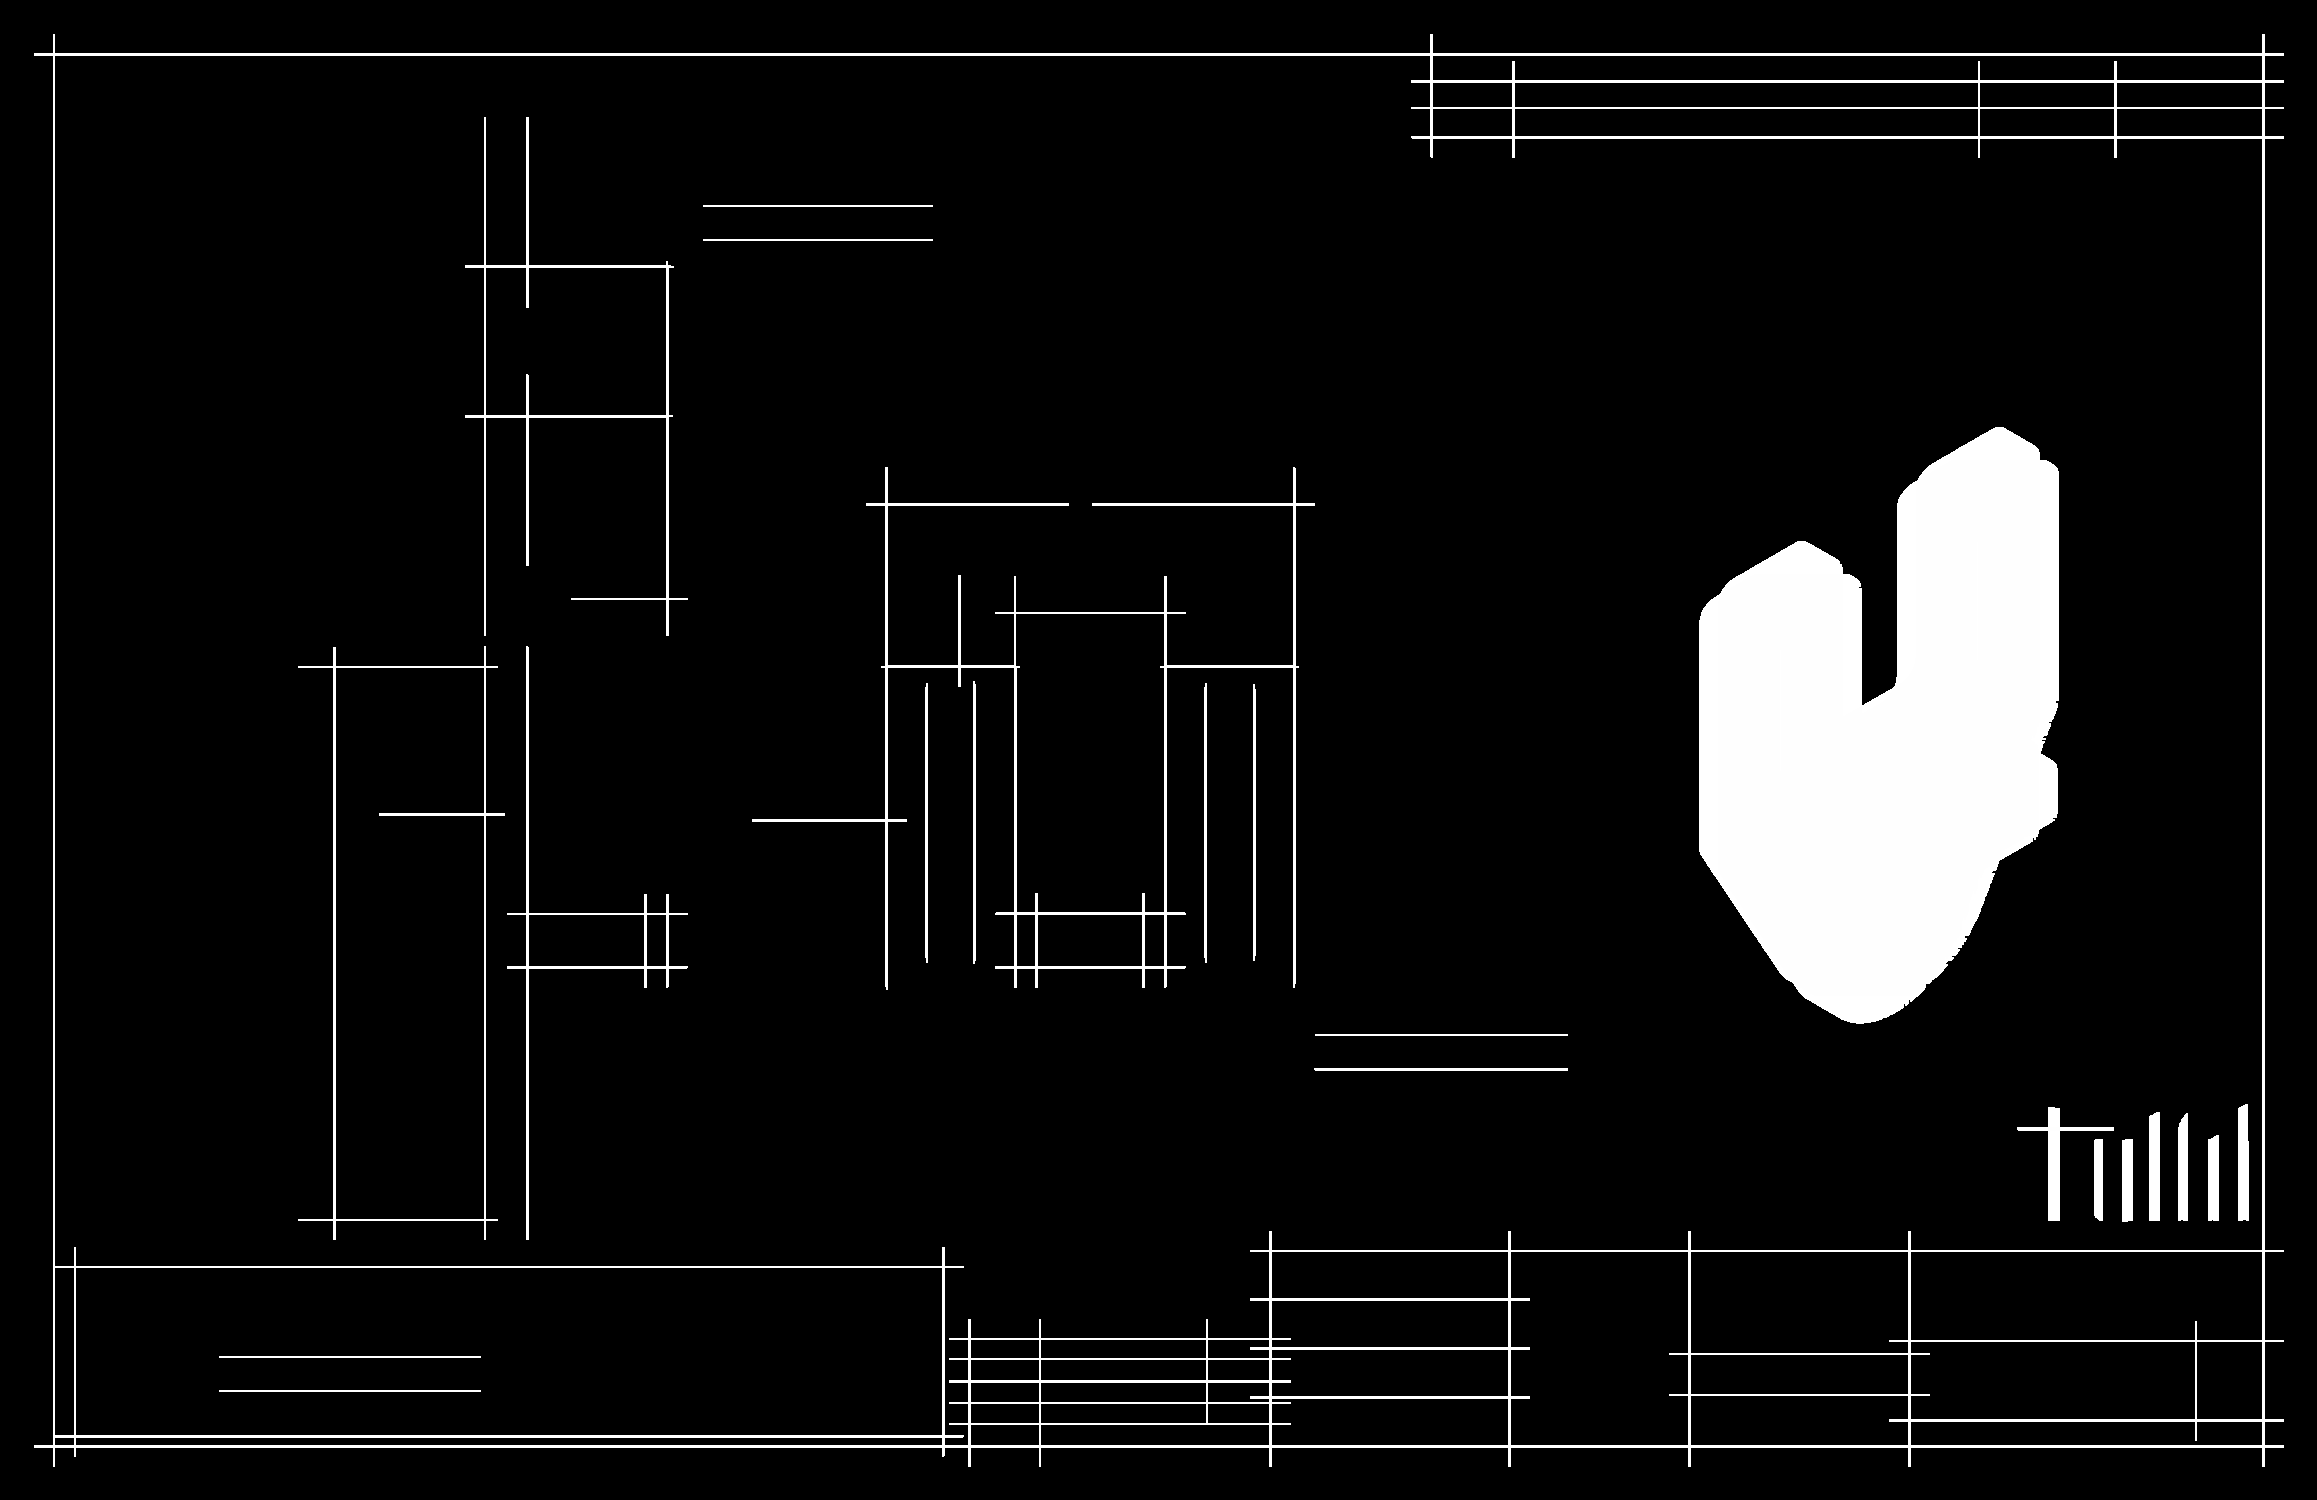

In [4]:
Image.fromarray(structures[0])

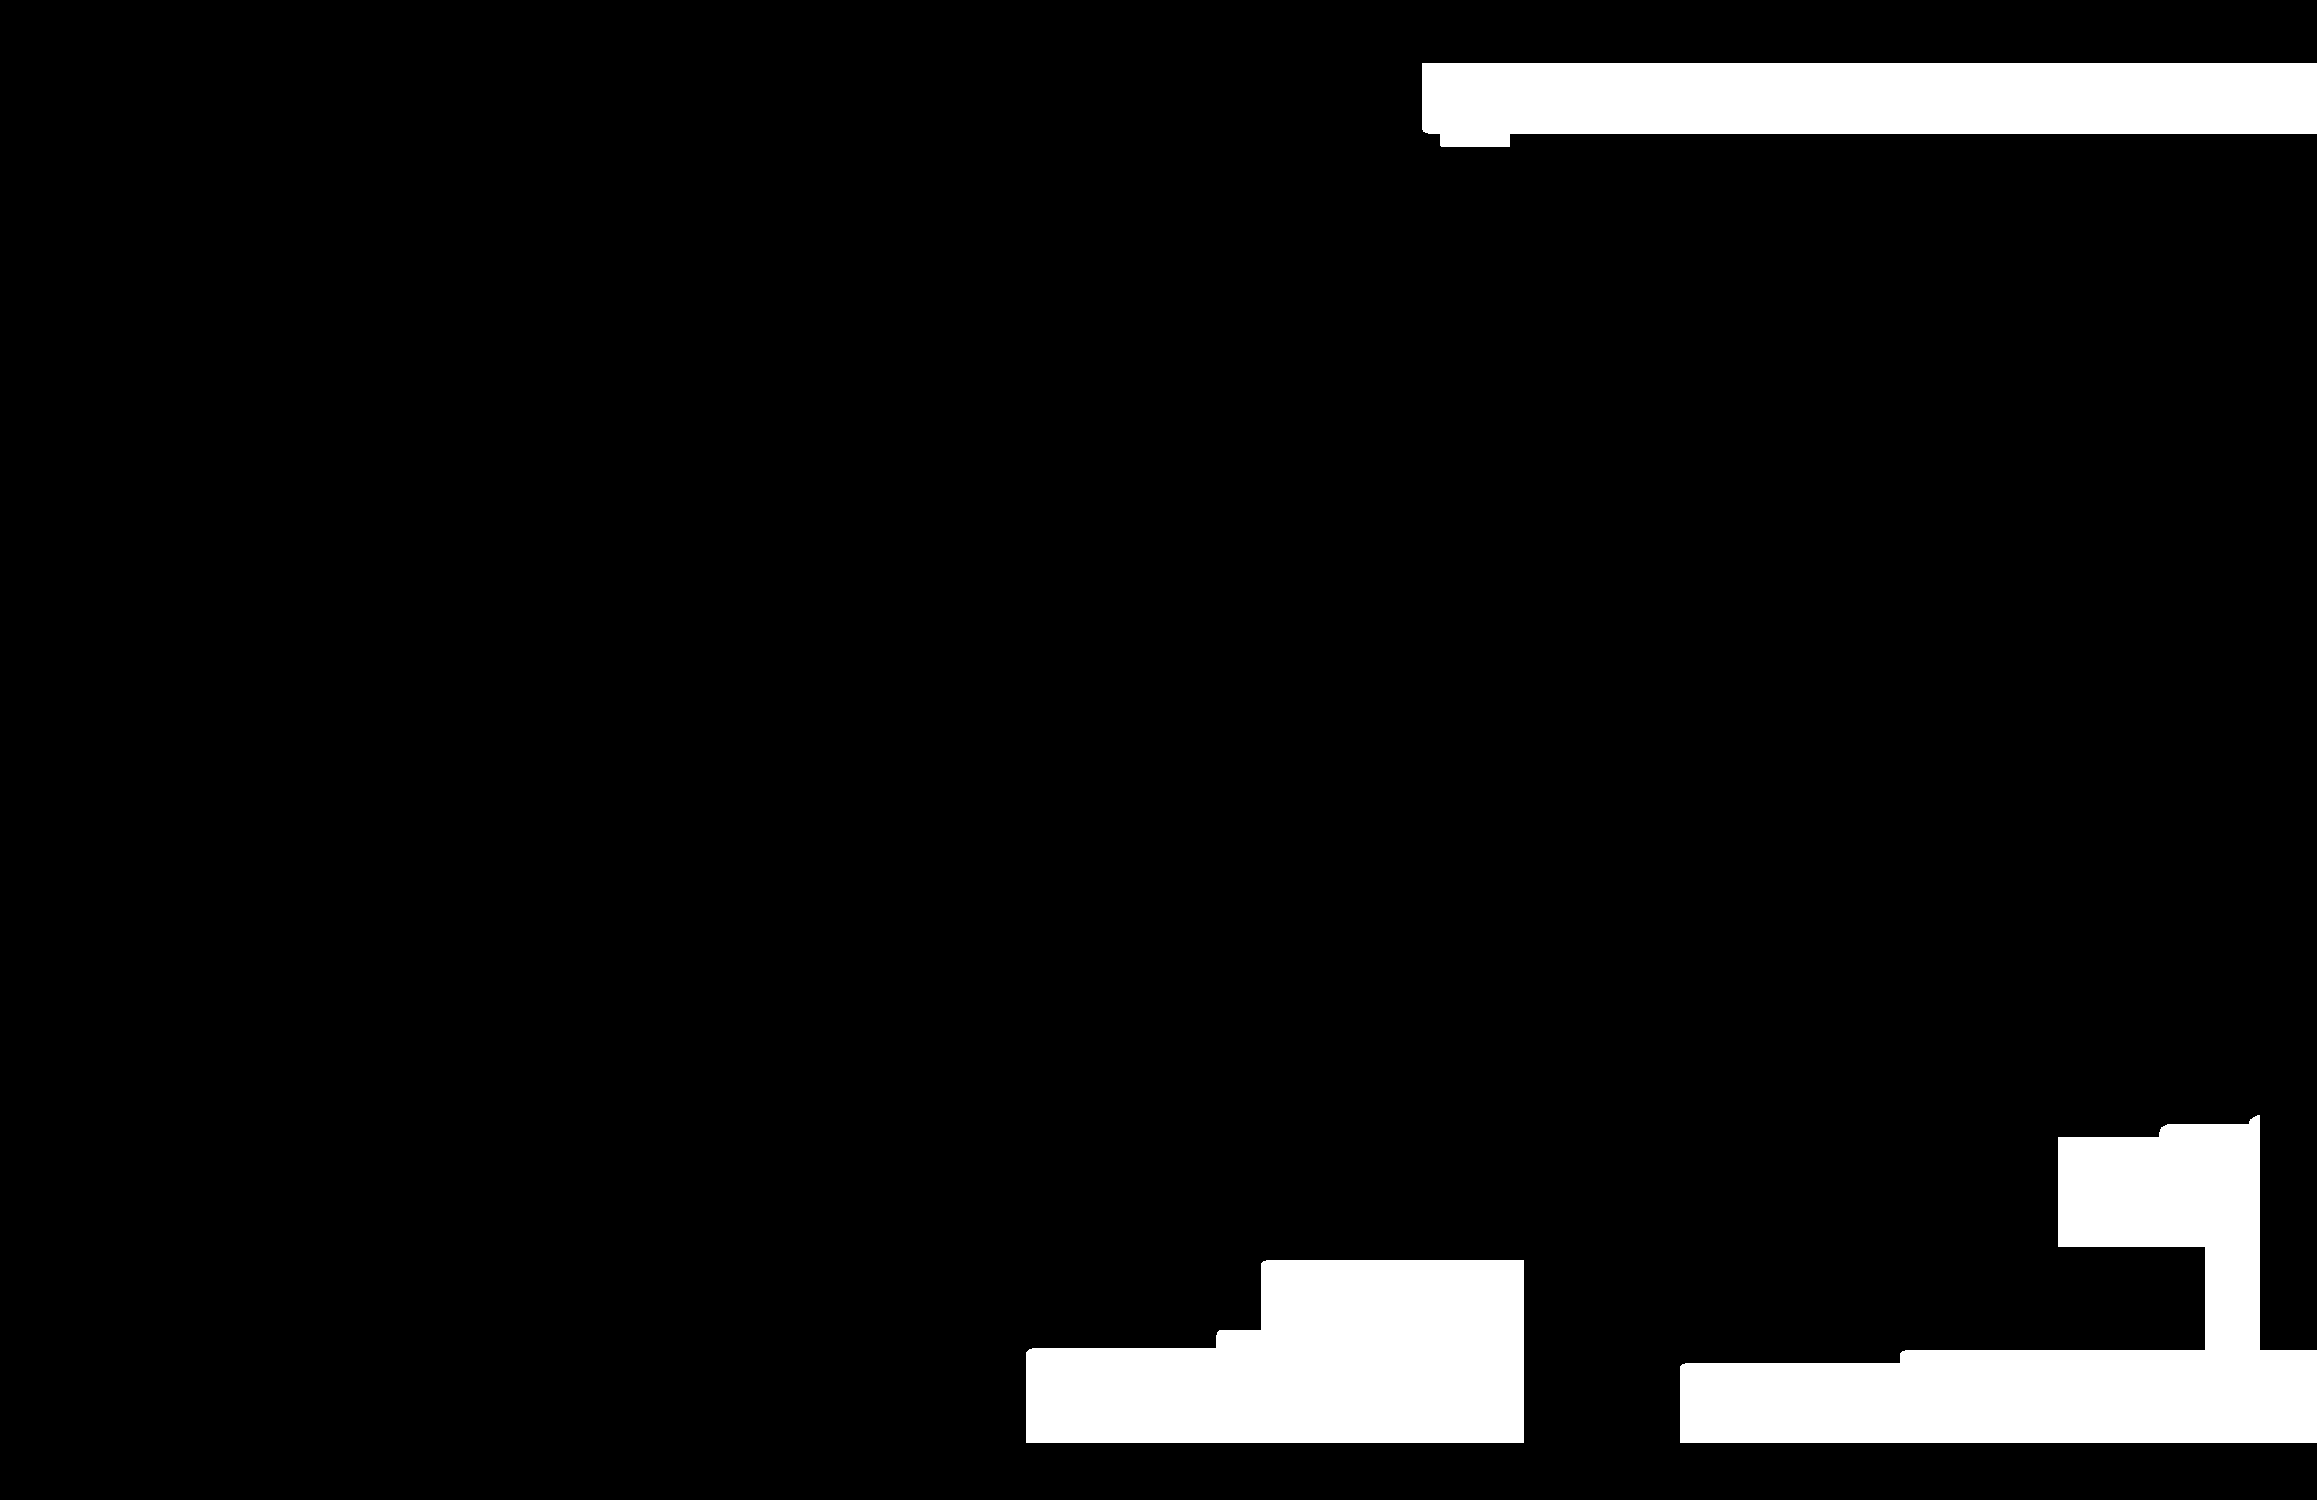

In [12]:
img_copy = template.copy()
gray = cv2.cvtColor(img_copy, cv2.COLOR_BGR2GRAY)

thresh = cv2.adaptiveThreshold(
    gray, 255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY_INV,
    11, 2
)

kernel = np.ones((15, 15), np.uint8)
dilated = cv2.dilate(thresh, kernel, iterations=5)
kernel = np.ones((20, 20), np.uint8)
dilated = cv2.erode(dilated, kernel, iterations=5)

contours, hierarchy = cv2.findContours(
    dilated,
    cv2.RETR_CCOMP,
    cv2.CHAIN_APPROX_SIMPLE
)
len(contours), len(hierarchy[0])

Image.fromarray(dilated)

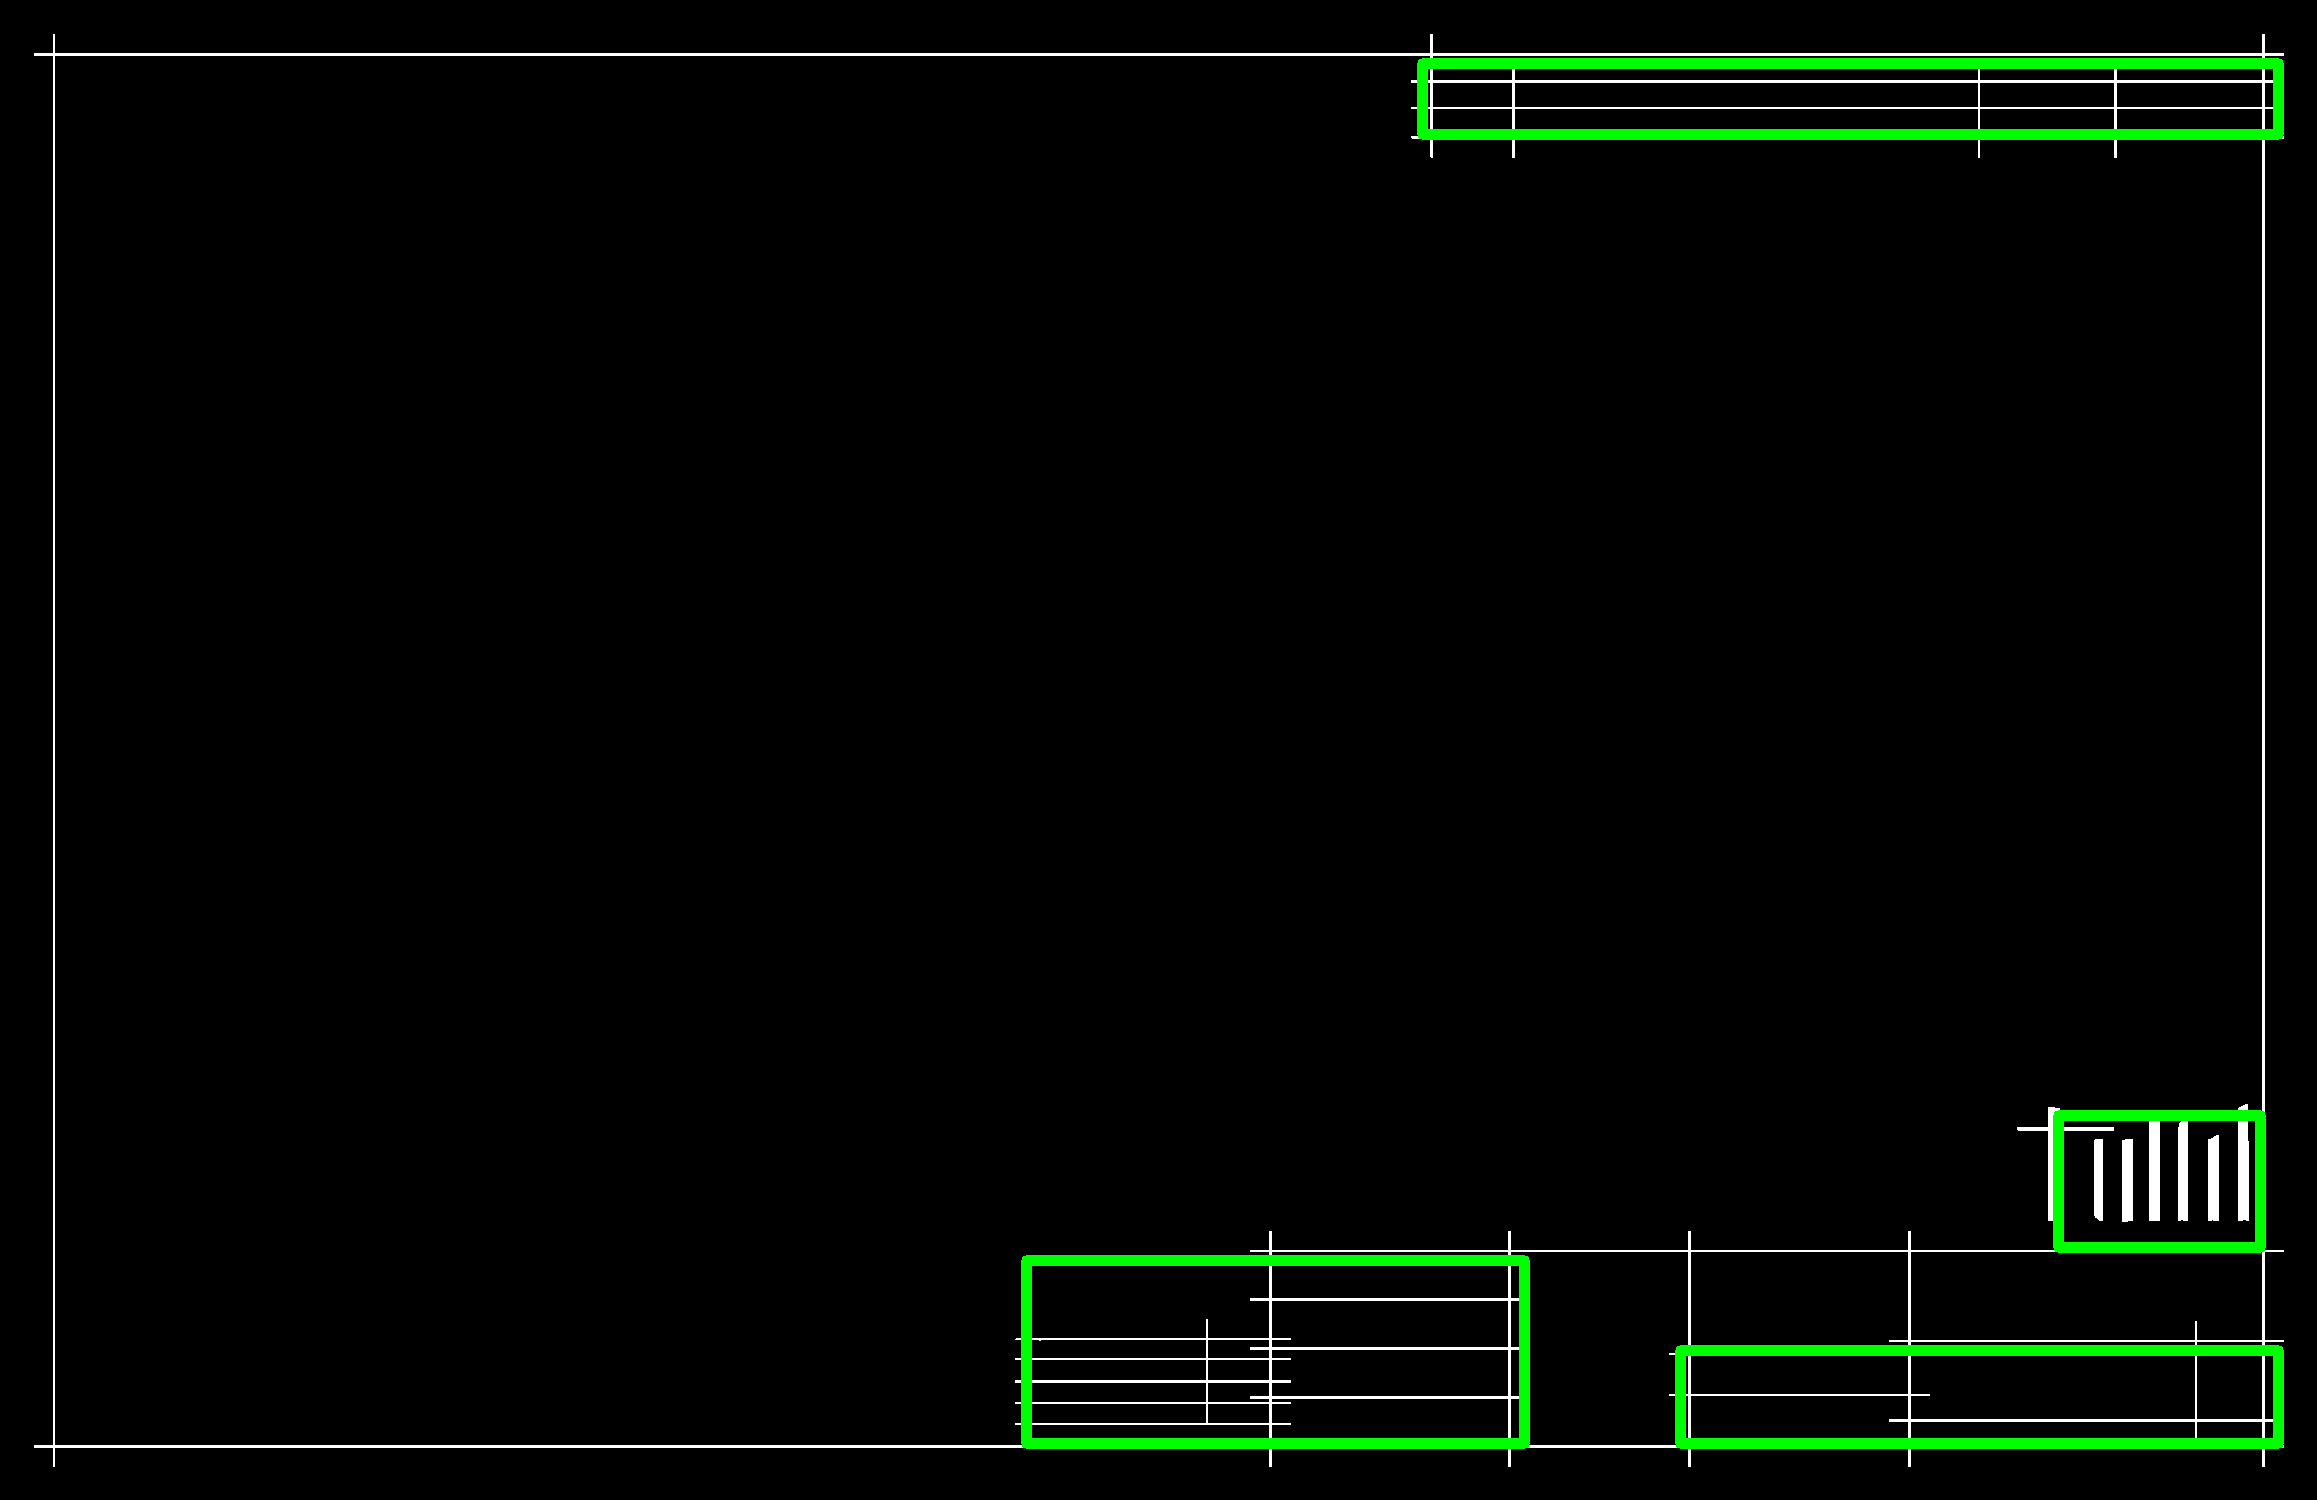

In [11]:
img_comp = template.copy()

for cnt, hie in zip(contours, hierarchy[0]):
    if cv2.contourArea(cnt) > 1000:
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(img_comp, (x, y), (x+w, y+h), (0, 255, 0), 10)

Image.fromarray(img_comp)